In [1]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 16.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rdkit
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import QED
from rdkit.Chem import MolSurf
from rdkit.Chem import rdFreeSASA as SASA
from tqdm.notebook import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = "/content/drive/My Drive/Toxicity Project/DATA/all_toxin_data.csv"
df = pd.read_csv(path)
print(f"Size of the dataset before NaN rows dropped: {len(df)}")
print(f"Number of missing value rows in the toxicity column: {sum(df['toxicity'].isna())}")
print(f"Number of missing value rows in the lethaldose column: {sum(df['lethaldose'].isna())}")
df = df.dropna(subset=["toxicity"])
print(f"Size of the dataset after NaN rows dropped: {len(df)}")
df["index"] = list(range(len(df))) 
df = df.set_index("index")
assert sum(df["toxicity"].isna()) == 0

Size of the dataset before NaN rows dropped: 3915
Number of missing value rows in the toxicity column: 2794
Number of missing value rows in the lethaldose column: 3466
Size of the dataset after NaN rows dropped: 1121


In [ ]:
df.head()

,Unnamed: 0,id,title,common_name,description,cas,pubchem_id,chemical_formula,weight,appearance,...,chembl_id,chemspider_id,biodb_id,synthesis_reference,structure_image_caption,synonyms_list,types,cellular_locations,tissues,pathways
index,,,,,,,,,,,,,,,,,,,,,
0,0,2,T3D0001,Arsenic,Arsenic(As) is a ubiquitous metalloid found in...,7440-38-2,104734,As,74.921600,Grey metallic solid.,...,NaN,94549,NaN,NaN,NaN,Arsenic ion\r\nArsenic(3+)\r\nArsenic(3+) ion\...,"[{'id': 1, 'type_name': 'Inorganic Compound', ...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...",[],[]
1,1,3,T3D0002,Lead,Lead is a soft and malleable heavy and post-tr...,7439-92-1,73212,Pb,207.976654,"Bluish-white metallic solid, turns grey when e...",...,NaN,65967,NaN,NaN,NaN,Lead (II) cation\r\nLead ion\r\nLead ion (Pb2+...,"[{'id': 1, 'type_name': 'Inorganic Compound', ...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...",[],[]
2,2,4,T3D0003,Mercury,Mercury is a metal that is a liquid at room te...,7439-97-6,26623,Hg,201.970642,Silver metallic liquid.,...,NaN,24800,NaN,NaN,NaN,Hg(2+)\r\nHg2+\r\nMercuric ion\r\nMercury ion\...,"[{'id': 1, 'type_name': 'Inorganic Compound', ...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...",[],[]
3,3,5,T3D0004,Vinyl chloride,"Vinyl chloride is a man-made organic compound,...",75-01-4,6338,C2H3Cl,61.992330,"Colorless gas, usually stored as a liquid.",...,NaN,NaN,NaN,NaN,NaN,Chloroethene\r\nChloroethylene\r\nMonochloroet...,"[{'id': 7, 'type_name': 'Organic Compound', 'c...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...",[],[]
4,4,7,T3D0006,Benzene,"Benzene is a toxic, volatile, flammable liquid...",71-43-2,241,C6H6,78.046950,Colorless liquid.,...,CHEMBL277500,236,NaN,"Copisarow, Maurice; Long, Cyril N H. The Fried...",NaN,Annulene\r\nAromatic alkane\r\nBenzeen\r\nBenz...,"[{'id': 7, 'type_name': 'Organic Compound', 'c...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...","[{'id': 4, 'name': 'Bone Marrow', 'created_at'...",[]


In [6]:
# Creating a dictionary for each type of injection, where the key - index of the substance, value - list of trials (could be several species). Each trial is also a list with the LD50 value, its type (mg/kg) and species
ORAL = {} # Oral
IP = {} # Intraperitoneal
SC = {} # Subcutaneous
IV = {} # Intravenous
INH = {} # Inhalation
DER = {} # Dermal

for i, tox in enumerate(list(df.toxicity)):
    tox = tox.split("LD50: ")
    if len(tox)>1:
        del(tox[0])
        tox = list(map(str.lower,tox))
        tox = [string.split(" ") for string in tox]   
        # print(tox)
        ORAL[i] = []
        IP[i] = []
        SC[i] = []
        IV[i] = []
        INH[i] = []
        DER[i] = []
        for line in tox:  
            try:
                line[0] = float(line[0])
            except ValueError:
                pass
            if line[1] == 'g/kg':
                if type(line[0]) is float:
                    line[0] = line[0]*1000
                    line[1] = 'mg/kg'
            elif line[1] == 'ug/kg':
                if type(line[0]) is float:
                    line[0] = line[0]/1000
                    line[1] = 'mg/kg'

            if "mg/kg" in str(line[0]):
                line[0] = line[0].split("mg/kg")[0]
                line.insert(1,"mg/kg")
                

            if ">" in str(line[0]) and str(line[0])[1:].isnumeric(): 
                line[0] = float(line[0].split(">")[-1]) #remove "larger than" sign ###407
            
            if "-" in str(line[0]) and type(line[0]) != float and "," not in str(line[0]):
                line[0] = np.mean([float(x) for x in str(line[0]).split("-")]) #convert range to mean ###401
                print("-------------------------")
                print(line)
            # add only values with 'mg/kg'
            if '(oral,' in line and line[1] == 'mg/kg':
                try:
                    ORAL[i].append([line[0],line[1],line[3]])
                except IndexError:
                    pass
            if '(intraperitoneal,' in line and line[1] == 'mg/kg':
                try:
                    IP[i].append([line[0],line[1],line[3]])
                except IndexError:
                    pass
            if '(subcutaneous,' in line and line[1] == 'mg/kg':
                try:
                    SC[i].append([line[0],line[1],line[3]])
                except IndexError:
                    pass
            if '(intravenous,' in line and line[1] == 'mg/kg':
                try:
                    IV[i].append([line[0],line[1],line[3]])
                except IndexError:
                    pass
            if '(inhalation,' in line and line[1] == 'mg/kg':
                try:
                    INH[i].append([line[0],line[1],line[3]])
                except IndexError:
                   pass
            if '(dermal,' in line and line[1] == 'mg/kg':
                try:
                    DER[i].append([line[0],line[1],line[3]])
                except IndexError:
                   pass
# delete the empty rows 
ORAL = {key:value for key,value in ORAL.items() if value != []}
IP = {key:value for key,value in IP.items() if value != []}
SC = {key:value for key,value in SC.items() if value != []}
IV = {key:value for key,value in IV.items() if value != []}
INH = {key:value for key,value in INH.items() if value != []}
DER = {key:value for key,value in DER.items() if value != []}

#ORAL #the biggest dataset, it has 715 rows (and there are several lists in some of them)

-------------------------
[1250.0, 'mg/kg', '(dermal,', 'rabbit)', '(t20)\r\n']
-------------------------
[85.0, 'mg/kg', '(oral,', 'rabbit)', '(t20)\r\n']
-------------------------
[451.0, 'mg/kg', '(oral,', 'mouse)', '(l156)']
-------------------------
[28.5, 'mg/kg', '(oral,', 'human)', '(t30)']
-------------------------
[25.0, 'mg/kg', '(dermal,', 'guinea', 'pig)', '(l1186)\nlc50:', '11', 'mg/m3', '(inhalation,', 'rat)', '(l1186)']
-------------------------
[1290.0, 'mg/kg', '(dermal,', 'rabbit)', '(l723)']
-------------------------
[487.5, 'mg/kg/day', '(oral,', 'rat)', '(l276)']
-------------------------
[10.5, 'mg/kg', '', '(oral,', 'mouse)', '(l930)']
-------------------------
[3332.0, 'mg/kg', '(oral,', 'rat)', '(l957)\n']
-------------------------
[1955.0, 'mg/kg', '(oral,', 'mouse)', '(l910)\n\r']
-------------------------
[57.5, 'mg/m3', '(chronic', 'inhalation,', 'rabbit)', '(l477)\n\r']
-------------------------
[3500.0, 'mg/kg', '(percutaneous,', 'rabbit)', '(t58)']
----

In [ ]:
len(ORAL)

719

In [7]:
rat_dict = {key: [value_list for value_list in value if value_list[2] == 'rat)'] 
                 for key, value in ORAL.items() if any(value_list[2] == 'rat)' 
                                                    for value_list in value)}

print(rat_dict)

mouse_dict = {key: [value_list for value_list in value if value_list[2] == 'mouse)'] 
                 for key, value in ORAL.items() if any(value_list[2] == 'mouse)' 
                                                                for value_list in value)}
print(mouse_dict)

{0: [[763.0, 'mg/kg', 'rat)']], 3: [[500.0, 'mg/kg', 'rat)']], 4: [[3306.0, 'mg/kg', 'rat)']], 5: [[225.0, 'mg/kg', 'rat)']], 8: [[87.0, 'mg/kg', 'rat)']], 9: [[1010.0, 'mg/kg', 'rat)']], 10: [[1315.0, 'mg/kg', 'rat)']], 12: [[38.0, 'mg/kg', 'rat)']], 14: [[200.0, 'mg/kg', 'rat)']], 15: [[90.0, 'mg/kg', 'rat)']], 16: [[39.0, 'mg/kg', 'rat)']], 17: [[113.0, 'mg/kg', 'rat)']], 18: [[309.0, 'mg/kg', 'rat)']], 19: [[11000.0, 'mg/kg', 'rat)']], 20: [[50.0, 'mg/kg', 'rat)']], 21: [[3835.0, 'mg/kg', 'rat)']], 23: [[108.0, 'mg/kg', 'rat)']], 24: [[6000.0, 'mg/kg', 'rat)']], 25: [[46.0, 'mg/kg', 'rat)']], 26: [[6.8, 'mg/kg', 'rat)']], 27: [[3820.0, 'mg/kg', 'rat)']], 28: [[3.0, 'mg/kg', 'rat)']], 29: [[1000.0, 'mg/kg', 'rat)']], 31: [[27.0, 'mg/kg', 'rat)']], 32: [[2800.0, 'mg/kg', 'rat)']], 33: [[3980.0, 'mg/kg', 'rat)']], 34: [[6170.0, 'mg/kg', 'rat)']], 35: [[87.0, 'mg/kg', 'rat)']], 36: [[2300.0, 'mg/kg', 'rat)']], 39: [[66.0, 'mg/kg', 'rat)']], 40: [[1590.0, 'mg/kg', 'rat)']], 41: [[200.0,

In [ ]:
print(f"Size of rat_dict: {len(rat_dict)}")
print(f"Size of mouse_dict: {len(mouse_dict)}")

Size of rat_dict: 565
Size of mouse_dict: 136


In [8]:
# Extracting only the LD50 values for rat:
rat_dict = {k: v[0][0] for k, v in rat_dict.items()}
print(rat_dict)

{0: 763.0, 3: 500.0, 4: 3306.0, 5: 225.0, 8: 87.0, 9: 1010.0, 10: 1315.0, 12: 38.0, 14: 200.0, 15: 90.0, 16: 39.0, 17: 113.0, 18: 309.0, 19: 11000.0, 20: 50.0, 21: 3835.0, 23: 108.0, 24: 6000.0, 25: 46.0, 26: 6.8, 27: 3820.0, 28: 3.0, 29: 1000.0, 31: 27.0, 32: 2800.0, 33: 3980.0, 34: 6170.0, 35: 87.0, 36: 2300.0, 39: 66.0, 40: 1590.0, 41: 200.0, 42: 3460.0, 43: 200.0, 44: 80.0, 46: 18.0, 48: 5000.0, 49: 2590.0, 50: 0.201, 51: 630.0, 52: 644.0, 54: 490.0, 55: 200.0, 56: 1600.0, 58: 680.0, 60: 854.0, 61: 3500.0, 62: 268.0, 64: 3500.0, 66: 250.0, 67: 2290.0, 68: 2000.0, 69: 480.0, 70: 177.0, 71: 756.0, 72: 9000.0, 73: 58.0, 74: 102.0, 77: 11.0, 79: 132.0, 80: 150.0, 81: 2600.0, 82: 595.0, 83: 2.0, 85: 6700.0, 86: 100.0, 87: 113.0, 90: 350.0, 91: 1630.0, 93: 750.0, 95: 837.0, 96: 471.0, 97: 959.0, 98: 207.0, 99: 500.0, 108: 756.0, 113: 820.0, 114: 48.0, 116: 1.0, 120: 56.2, 121: 56.0, 122: 20.0, 123: 1.0, 124: 41.0, 129: 639.0, 130: 2800.0, 131: 2700.0, 132: 1213.0, 139: 185.0, 141: 41.0, 

In [9]:
# Extracting only the LD50 values for mouse_dict:
mouse_dict = {k: v[0][0] for k, v in mouse_dict.items()}
print(mouse_dict)

{7: 36.0, 11: 2402.0, 37: 5289.0, 47: 500.0, 58: 451.0, 60: 500.0, 62: 790.0, 65: 21.0, 76: 3.7, 106: 4170.0, 107: 344.0, 110: 100.0, 118: 205.0, 125: 42.0, 127: 700.0, 129: 138.0, 133: 380.0, 137: 316.0, 140: 145.0, 147: 315.0, 155: 0.27, 159: 10600.0, 177: 35.0, 179: 170.0, 183: 33.0, 186: 310.0, 191: 72.0, 192: 312.0, 194: 1166.0, 402: 1760.0, 403: 1955.0, 405: 500.0, 410: 100.0, 445: 7950.0, 449: 57.0, 453: 500.0, 455: 2970.0, 461: 841.0, 463: 97.0, 464: 87.0, 466: 131.0, 476: 89.0, 478: 600.0, 494: 55.0, 495: 10.0, 496: 2.3, 501: 480.0, 505: 450.0, 506: 49.5, 507: 275.0, 521: 50.0, 524: 305.0, 545: 1897.0, 552: 70.0, 553: 60.0, 554: 6000.0, 555: 55.0, 557: 18.0, 560: 2152.0, 567: 1450.0, 568: 160.0, 580: 91.0, 581: 123.0, 582: 275.0, 588: 142.0, 592: 222.0, 596: 980.0, 601: 50.0, 602: 1027.0, 608: 23.0, 615: 1950.0, 623: 230.0, 624: 1800.0, 627: 269.0, 631: 45.5, 634: 28.0, 636: 3700.0, 638: 19.0, 640: 65.0, 646: 1623.0, 651: 3120.0, 660: 9100.0, 662: 1400.0, 673: 23.0, 695: 3621.

In [10]:
# Add new columns to data frame:
df['LD50_rat'] = None
df['LD50_mouse'] = None

# Assign values from dictionary to matching rows in data frame
for key, value in rat_dict.items():
    df.loc[key, 'LD50_rat'] = value
    
for key, value in mouse_dict.items():
    df.loc[key, 'LD50_mouse'] = value

In [11]:
# Drop rows which have NaN in BOTH LD50_rat and LD50_mouse:
df.dropna(subset=['LD50_rat', 'LD50_mouse'], how='all', inplace=True)

print(f"Total rows left: {len(df)}")

Total rows left: 669


In [ ]:
print(f"Number of NaN in LD50_rat: {df['LD50_rat'].isna().sum()}")
print(f"Number of NaN in LD50_mouse: {df['LD50_mouse'].isna().sum()}")

print(f"How many LD50_rat are left in df? {len(df) - df['LD50_rat'].isna().sum()}")
print(f"How many LD50_mouse are left in df? {len(df) - df['LD50_mouse'].isna().sum()}")

Number of NaN in LD50_rat: 104
Number of NaN in LD50_mouse: 533
How many LD50_rat are left in df? 565
How many LD50_mouse are left in df? 136


In [ ]:
df

,Unnamed: 0,id,title,common_name,description,cas,pubchem_id,chemical_formula,weight,appearance,...,biodb_id,synthesis_reference,structure_image_caption,synonyms_list,types,cellular_locations,tissues,pathways,LD50_rat,LD50_mouse
index,,,,,,,,,,,,,,,,,,,,,
0,0,2,T3D0001,Arsenic,Arsenic(As) is a ubiquitous metalloid found in...,7440-38-2,104734,As,74.921600,Grey metallic solid.,...,NaN,NaN,NaN,Arsenic ion\r\nArsenic(3+)\r\nArsenic(3+) ion\...,"[{'id': 1, 'type_name': 'Inorganic Compound', ...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...",[],[],763.0,None
3,3,5,T3D0004,Vinyl chloride,"Vinyl chloride is a man-made organic compound,...",75-01-4,6338,C2H3Cl,61.992330,"Colorless gas, usually stored as a liquid.",...,NaN,NaN,NaN,Chloroethene\r\nChloroethylene\r\nMonochloroet...,"[{'id': 7, 'type_name': 'Organic Compound', 'c...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...",[],[],500.0,None
4,4,7,T3D0006,Benzene,"Benzene is a toxic, volatile, flammable liquid...",71-43-2,241,C6H6,78.046950,Colorless liquid.,...,NaN,"Copisarow, Maurice; Long, Cyril N H. The Fried...",NaN,Annulene\r\nAromatic alkane\r\nBenzeen\r\nBenz...,"[{'id': 7, 'type_name': 'Organic Compound', 'c...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...","[{'id': 4, 'name': 'Bone Marrow', 'created_at'...",[],3306.0,None
5,5,8,T3D0007,Cadmium,Cadmium (group IIB of the periodic table of el...,7440-43-9,31193,Cd,113.903358,Bluish-white metallic solid.,...,NaN,NaN,NaN,Cadmium ion\r\nCadmium(2+)\r\nCadmium(2+) ion\...,"[{'id': 1, 'type_name': 'Inorganic Compound', ...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...",[],[],225.0,None
7,8,12,T3D0011,Chloroform,Chloroform is found in spearmint. Indirect foo...,67-66-3,6212,CHCl3,117.914380,Colorless liquid.,...,NaN,NaN,NaN,"1,1,1-Trichloromethane\r\nCF\r\nCHCl3\r\nFormy...","[{'id': 7, 'type_name': 'Organic Compound', 'c...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...",[],[],None,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,2786,3807,T3D3753,Butenolide,Butenolide is a mycotoxin found in various spe...,16275-44-8,27790,C6H7NO3,NaN,White powder.,...,NaN,NaN,NaN,4-acetamido-4-Hydroxy-2-butenoic acid gamma-la...,"[{'id': 7, 'type_name': 'Organic Compound', 'c...","[{'id': 1, 'name': 'Cytoplasm', 'created_at': ...",[],[],None,275.0
1027,2885,3913,T3D3858,HPTE,"HPTE or 2,2-bis(p-hydroxyphenyl)-1,1,1-trichlo...",2971-36-0,76302,C14H11Cl3O2,NaN,White powder.,...,NaN,NaN,NaN,"1,1,1-Trichloro-2,2-bis(4-hydroxyphenyl)ethane...","[{'id': 7, 'type_name': 'Organic Compound', 'c...","[{'id': 3, 'name': 'Membrane', 'created_at': '...",[],[],3460.0,None
1092,3460,4828,T3D4773,Capric acid,Capric acid is a member of the series of fatty...,334-48-5,2969,C10H20O2,NaN,White powder.,...,NaN,NaN,NaN,1-Nonanecarboxylate\r\n1-Nonanecarboxylic acid...,"[{'id': 7, 'type_name': 'Organic Compound', 'c...","[{'id': 2, 'name': 'Extracellular', 'created_a...","[{'id': 38, 'name': 'Stratum Corneum', 'create...","[{'id': 45, 'name': 'Beta Oxidation of Very Lo...",3730.0,None


In [12]:
# Converting LD50 columns to numeric:
df['LD50_rat'] = pd.to_numeric(df['LD50_rat'], errors='coerce')
df['LD50_mouse'] = pd.to_numeric(df['LD50_mouse'], errors='coerce')

df.dtypes

Unnamed: 0                  object
id                          object
title                       object
common_name                 object
description                 object
cas                         object
pubchem_id                  object
chemical_formula            object
weight                      object
appearance                  object
melting_point               object
boiling_point               object
solubility                  object
route_of_exposure           object
mechanism_of_toxicity       object
metabolism                  object
toxicity                    object
lethaldose                  object
carcinogenicity             object
use_source                  object
min_risk_level              object
health_effects              object
symptoms                    object
treatment                   object
created_at                  object
updated_at                  object
wikipedia                   object
uniprot_id                  object
kegg_compound_id    

In [13]:
# Copying data and keeping only variables that could be interesting for analysis:
df_stats = df.copy()

df_stats = df_stats.loc[:, ['weight', 'melting_point', 'boiling_point', 'solubility', 'carcinogenicity', 'moldb_average_mass', 
                            'moldb_mono_mass', 'origin', 'state', 'logp', 'LD50_rat', 'LD50_mouse']]
df_stats

# maybe there are other variables, which could be interesting 
# I just selected some, that could be interesting and are also rather easy to transform to numeric

,weight,melting_point,boiling_point,solubility,carcinogenicity,moldb_average_mass,moldb_mono_mass,origin,state,logp,LD50_rat,LD50_mouse
index,,,,,,,,,,,,
0,74.921600,> 615°C,614 °C,NaN,"1, carcinogenic to humans. (L135)",74.92,74.919950677,Exogenous,Solid,NaN,763.0,NaN
3,61.992330,-153.7°C,-13.37 °C,"8.8 mg/mL at 25 °C [DELASSUS,PT & SCHMIDT,DD (...","1, carcinogenic to humans. (L135)",62.498,61.992327803,Exogenous,Gas,NaN,500.0,NaN
4,78.046950,5.5°C,80.1 °C,"1.79 mg/mL at 25°C [MAY,WE et al. (1983)]","1, carcinogenic to humans. (L135)",78.1118,78.046950192,Exogenous,Liquid,2.13,3306.0,NaN
5,113.903358,321°C,"1040 K\n(767 °C, 1413 °F)",NaN,"1, carcinogenic to humans. (L135)",112.41,113.902260961,Exogenous,Solid,NaN,225.0,NaN
7,117.914380,-63.2°C,61.2 °C,7.95 mg/mL at 25°C,"2B, possibly carcinogenic to humans. (L135)",119.378,117.914383153,Exogenous,Liquid,1.97,NaN,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1020,NaN,NaN,NaN,NaN,Not listed by IARC.,141.1247,141.042593095,Exogenous,Solid,NaN,NaN,275.0
1027,NaN,NaN,NaN,NaN,No indication of carcinogenicity (not listed b...,317.595,315.982462717,Exogenous,Solid,NaN,3460.0,NaN
1092,NaN,31.9°C,268.7°C,61.8 mg/L (at 25°C),No indication of carcinogenicity (not listed b...,172.2646,172.146329884,Endogenous,Solid,4.09,3730.0,NaN


In [14]:
# Creating numeric columns:

# Weight:
#print(df_stats['weight'].unique()) # to see whether there are other values besides numbers
df_stats['weight'] = pd.to_numeric(df_stats['weight'], errors='coerce') # converts any value that can't be converted to numeric to NaN

# Logp:
#print(df_stats['logp'].unique())
df_stats['logp'] = pd.to_numeric(df_stats['logp'], errors='coerce')

# State:
#print(df_stats['state'].value_counts())
df_stats["state"] = df_stats["state"].replace({"Solid" : 0, "Liquid": 1, "Gas": 2, "Solid or Liquid" : 0.5, "Gas or Liquid" : 1.5})

# Moldb_average_mass:
#print(df_stats['moldb_average_mass'].unique())
df_stats['moldb_average_mass'] = pd.to_numeric(df_stats['moldb_average_mass'], errors='coerce')

# Moldb_mono_mass:
#print(df_stats['moldb_mono_mass'].unique())
df_stats['moldb_mono_mass'] = pd.to_numeric(df_stats['moldb_mono_mass'], errors='coerce')

# Origin:
#print(df_stats['origin'].value_counts())
df_stats["origin"] = df_stats["origin"].replace({"Exogenous" : 0, "Endogenous": 1})


In [15]:
# melting_point:
def condition_melt(line):
  if type(line) == str:
    if line[-2:] == '°C':
      try:
        return float(line[:-2])
      except ValueError:
        pass
      
df_stats['melting_point'] = df_stats['melting_point'].apply(condition_melt)
print(f"not Nan in melting_point {len(df) - df['melting_point'].isna().sum()}")

# boiling_point:
df_stats['boiling_point'] = df_stats['boiling_point'].apply(condition_melt)
print(f"not Nan in boiling_point {len(df) - df['boiling_point'].isna().sum()}")

# solubility:
def condition_sol(line):
  if type(line) == str:
    line = line.split(" ") 
    if len(line) > 1:
      if line[1] == 'mg/mL' or line[1] == 'g/L' or line[1] == 'mg/ml':
        try:
          return float(line[0])
        except ValueError:
          pass
      elif line[1] == 'mg/L' or line[1] == 'mg/l':
        return float(line[0])/1000

df_stats['solubility'] = df_stats['solubility'].apply(condition_sol)
print(f"not Nan in solubility {len(df) - df['solubility'].isna().sum()}")

# carcinogenicity:
def condition(x):
  if type(x) == str:
    line_new = x.split(" ") 
    if line_new[1] == 'carcinogenic':
      return 1
    elif line_new[0] == 'No':
      return 0
    elif line_new[1] == 'possibly' or line_new[2] == 'possibly':
      return 0.5

df_stats['carcinogenicity'] = df_stats['carcinogenicity'].apply(condition)
print(f"not Nan in carcinogenicity {len(df) - df['carcinogenicity'].isna().sum()}")

not Nan in melting_point 381
not Nan in boiling_point 108
not Nan in solubility 432
not Nan in carcinogenicity 669


In [16]:
df_stats.dtypes

weight                float64
melting_point         float64
boiling_point         float64
solubility            float64
carcinogenicity       float64
moldb_average_mass    float64
moldb_mono_mass       float64
origin                  int64
state                 float64
logp                  float64
LD50_rat              float64
LD50_mouse            float64
dtype: object

In [ ]:
df_stats

,weight,melting_point,boiling_point,solubility,carcinogenicity,moldb_average_mass,moldb_mono_mass,origin,state,logp,LD50_rat,LD50_mouse
index,,,,,,,,,,,,
0,74.921600,NaN,NaN,NaN,1.0,74.9200,74.919951,0,0.0,NaN,763.0,NaN
3,61.992330,-153.7,-13.37,8.8000,1.0,62.4980,61.992328,0,2.0,NaN,500.0,NaN
4,78.046950,5.5,80.10,1.7900,1.0,78.1118,78.046950,0,1.0,2.13,3306.0,NaN
5,113.903358,321.0,NaN,NaN,1.0,112.4100,113.902261,0,0.0,NaN,225.0,NaN
7,117.914380,-63.2,61.20,7.9500,0.5,119.3780,117.914383,0,1.0,1.97,NaN,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1020,NaN,NaN,NaN,NaN,NaN,141.1247,141.042593,0,0.0,NaN,NaN,275.0
1027,NaN,NaN,NaN,NaN,0.0,317.5950,315.982463,0,0.0,NaN,3460.0,NaN
1092,NaN,31.9,268.70,0.0618,0.0,172.2646,172.146330,1,0.0,4.09,3730.0,NaN


In [ ]:
# From here on, I just copied the code from Analysis.1:

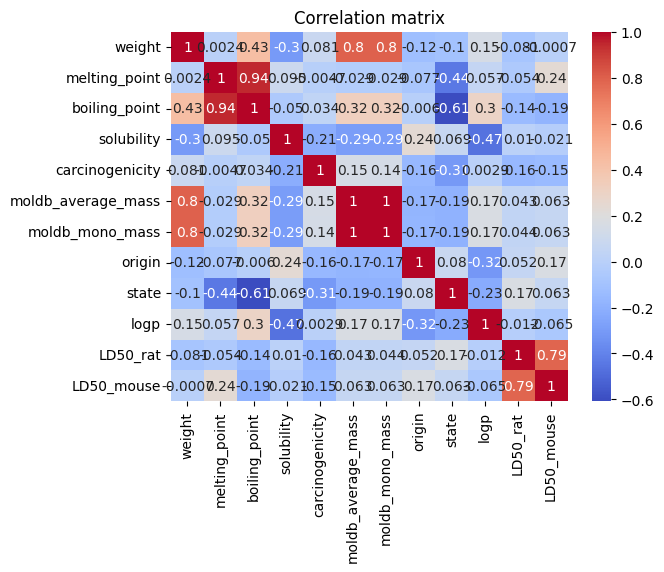

In [ ]:
#Correlation

import seaborn as sns
import matplotlib.pyplot as plt

corr_mat = df_stats.corr()

sns.heatmap(corr_mat, annot=True, cmap= "coolwarm")
plt.title("Correlation matrix")
plt.show()

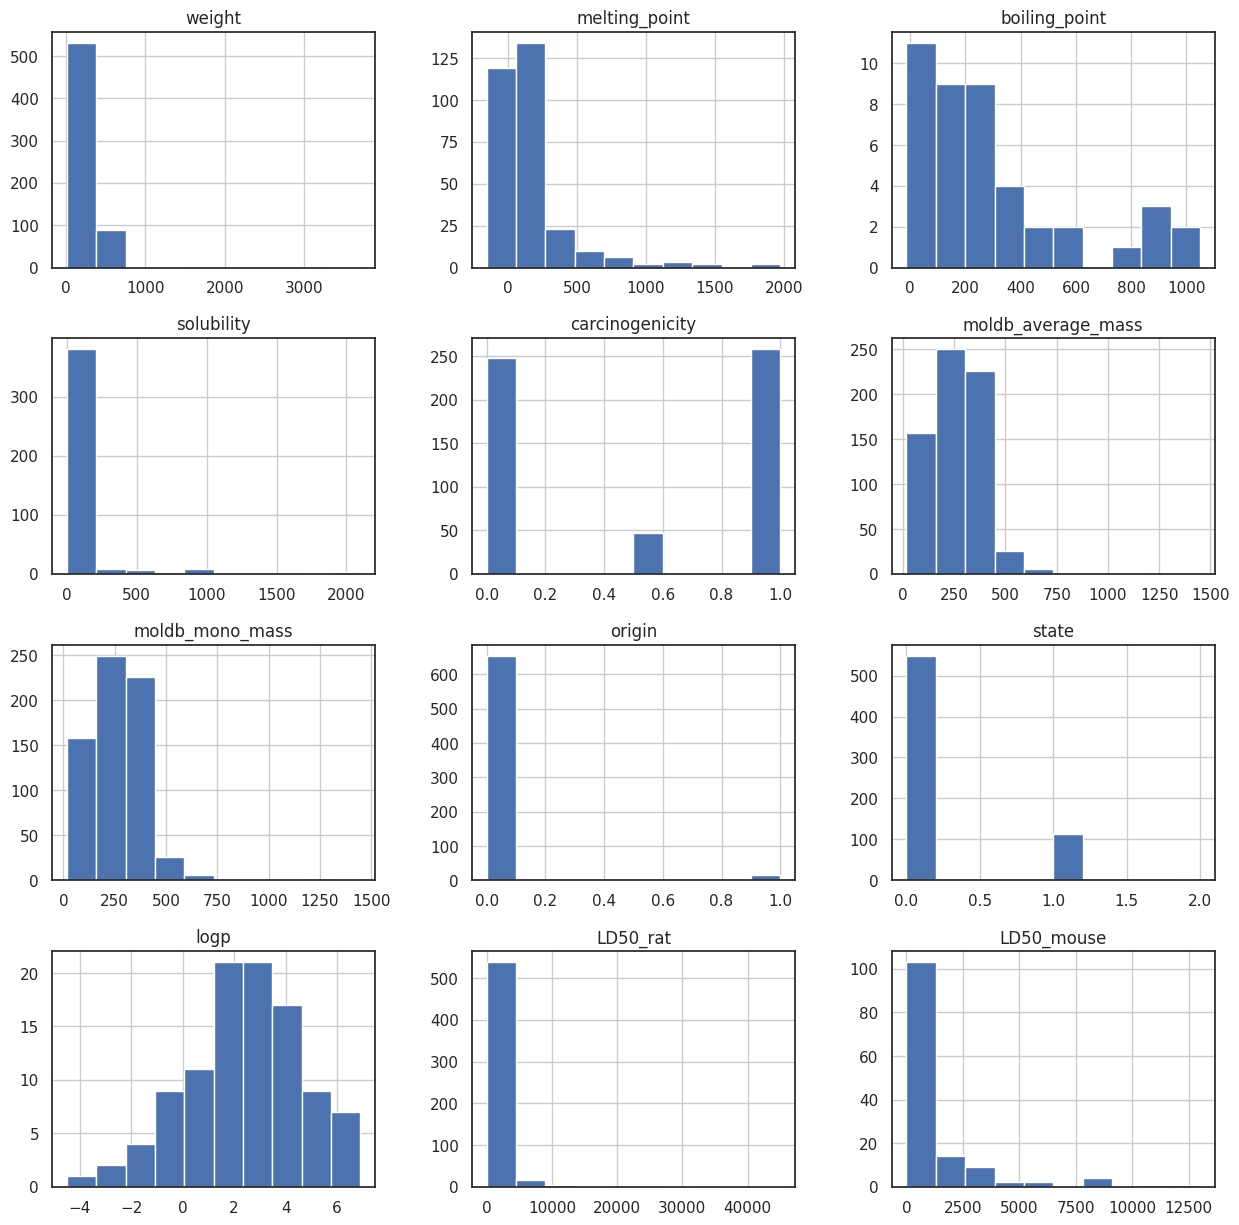

In [ ]:
#Histogram

sns.set(rc={"figure.figsize":(15,15)})
sns.set_style("white")
df_stats.hist()
plt.show()

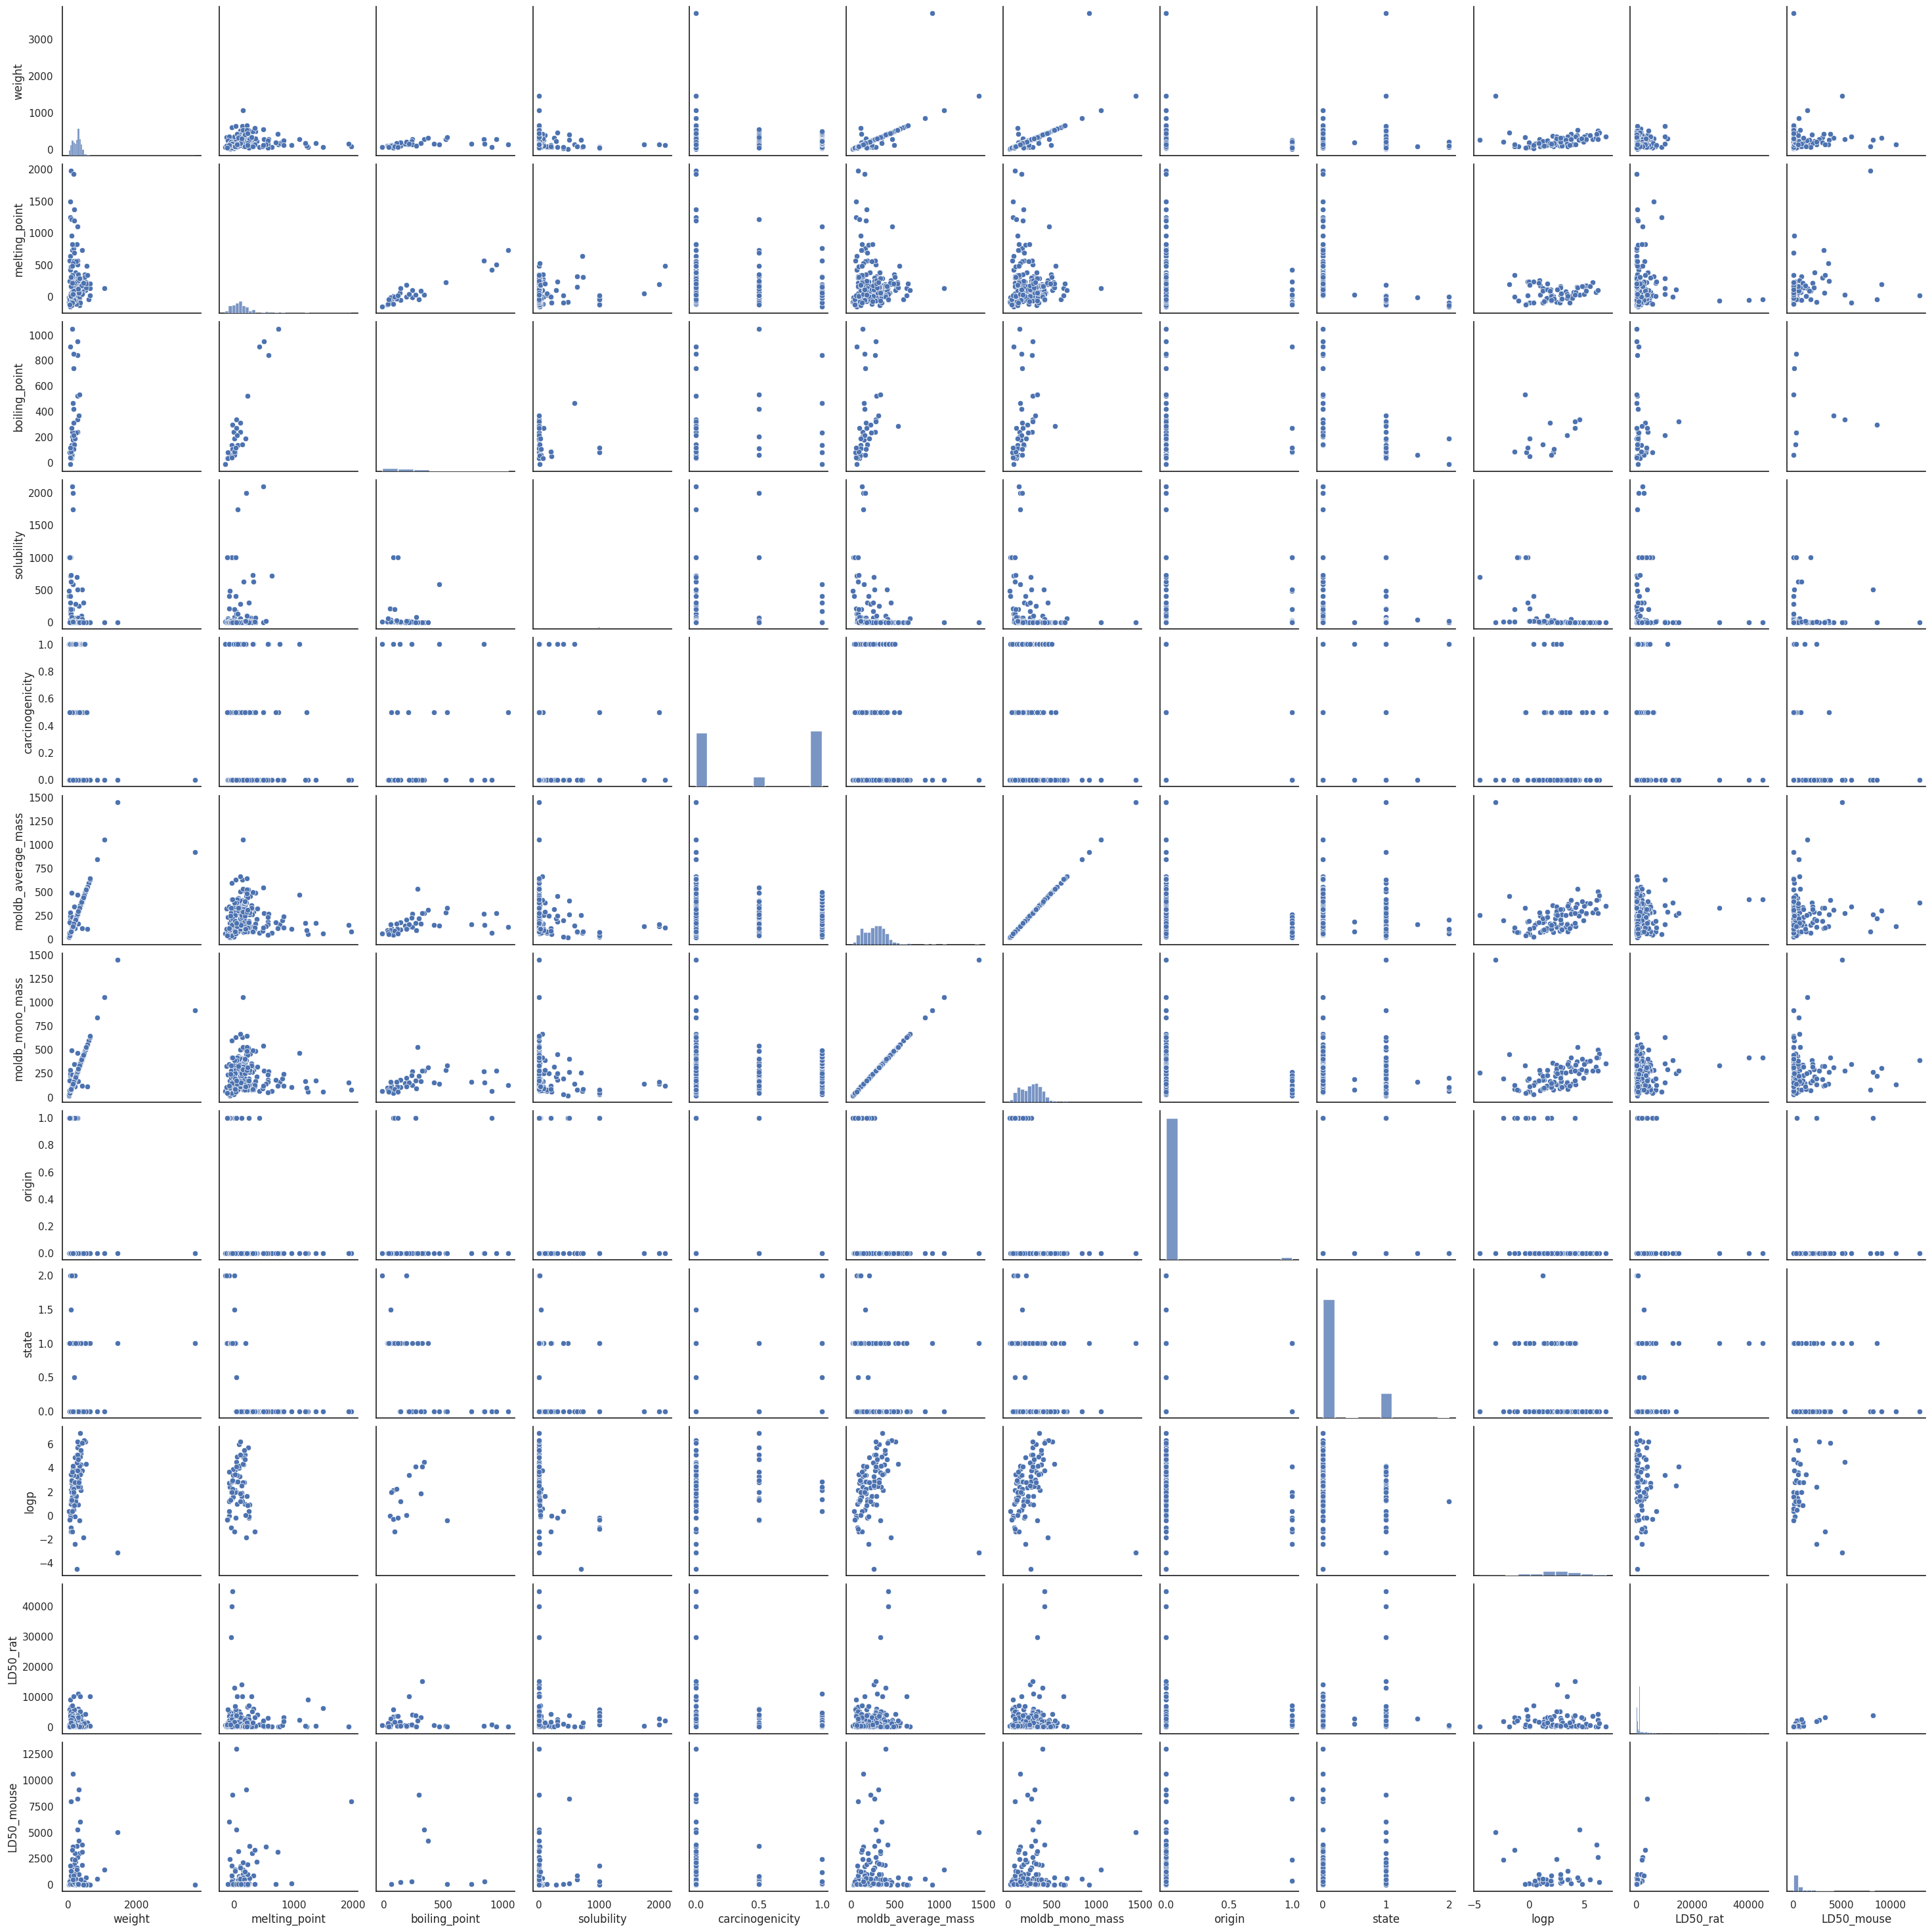

In [ ]:
#Pairplot

sns.pairplot(df_stats)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


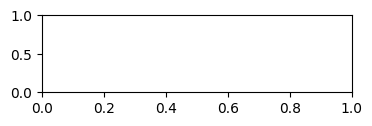

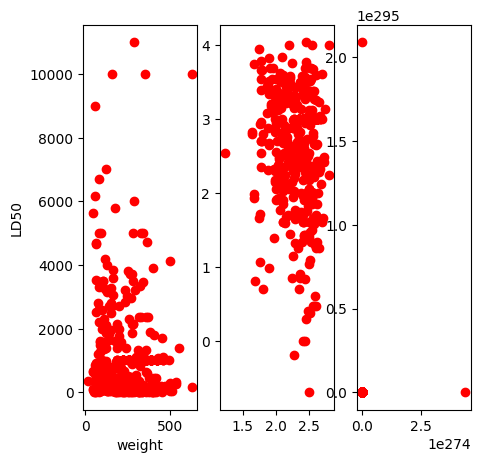

In [72]:
import statsmodels.formula.api as sm

# LD50_rat vs Weight
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(5, 5))

ax0.scatter(df_stats['weight'],df_stats['LD50_rat'], color='red')
ax0.set(xlabel='weight', ylabel='LD50')

log_y1 = np.log10(df_stats['LD50_rat'])
log_x = np.log10(df_stats['weight'])
df1 = pd.DataFrame({'x': log_x, 'y': log_y1})
ax1.scatter(log_x, log_y1, color='red')

exp_y1 = np.exp(df_stats['LD50_rat'])
exp_x = np.exp(df_stats['weight'])
df1 = pd.DataFrame({'x': exp_x, 'y': exp_y1})
ax2.scatter(exp_x, exp_y1, color='red')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


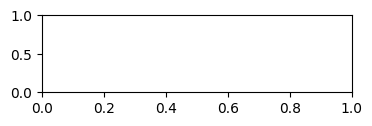

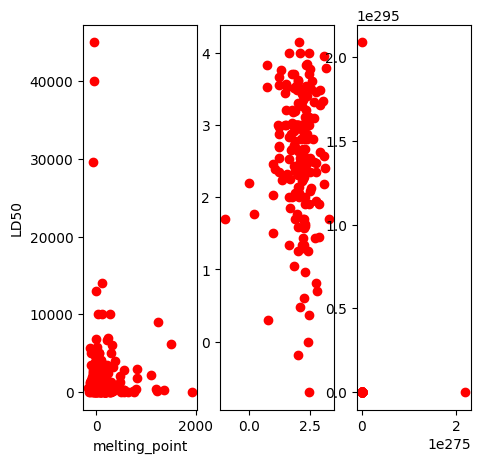

In [73]:
# LD50_rat vs melting_point
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(5, 5))

ax0.scatter(df_stats['melting_point'],df_stats['LD50_rat'], color='red')
ax0.set(xlabel='melting_point', ylabel='LD50')

log_y1 = np.log10(df_stats['LD50_rat'])
log_x = np.log10(df_stats['melting_point'])
df1 = pd.DataFrame({'x': log_x, 'y': log_y1})
ax1.scatter(log_x, log_y1, color='red')

exp_y1 = np.exp(df_stats['LD50_rat'])
exp_x = np.exp(df_stats['melting_point'])
df1 = pd.DataFrame({'x': exp_x, 'y': exp_y1})
ax2.scatter(exp_x, exp_y1, color='red')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


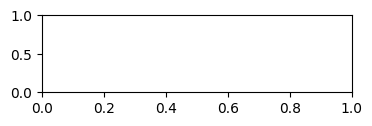

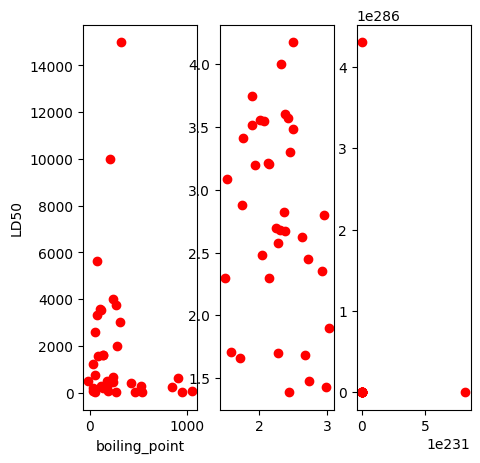

In [74]:
# LD50_rat vs boiling_point
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(5, 5))

ax0.scatter(df_stats['boiling_point'],df_stats['LD50_rat'], color='red')
ax0.set(xlabel='boiling_point', ylabel='LD50')

log_y1 = np.log10(df_stats['LD50_rat'])
log_x = np.log10(df_stats['boiling_point'])
df1 = pd.DataFrame({'x': log_x, 'y': log_y1})
ax1.scatter(log_x, log_y1, color='red')

exp_y1 = np.exp(df_stats['LD50_rat'])
exp_x = np.exp(df_stats['boiling_point'])
df1 = pd.DataFrame({'x': exp_x, 'y': exp_y1})
ax2.scatter(exp_x, exp_y1, color='red')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


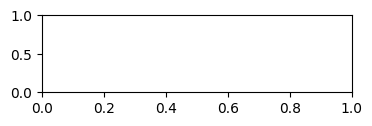

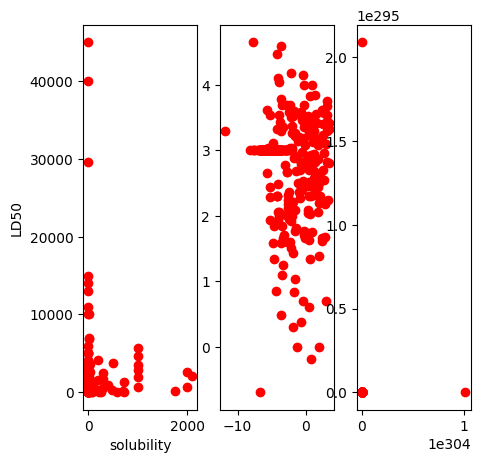

In [75]:
# LD50_rat vs solubility
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(5, 5))

ax0.scatter(df_stats['solubility'],df_stats['LD50_rat'], color='red')
ax0.set(xlabel='solubility', ylabel='LD50')

log_y1 = np.log10(df_stats['LD50_rat'])
log_x = np.log10(df_stats['solubility'])
df1 = pd.DataFrame({'x': log_x, 'y': log_y1})
ax1.scatter(log_x, log_y1, color='red')

exp_y1 = np.exp(df_stats['LD50_rat'])
exp_x = np.exp(df_stats['solubility'])
df1 = pd.DataFrame({'x': exp_x, 'y': exp_y1})
ax2.scatter(exp_x, exp_y1, color='red')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


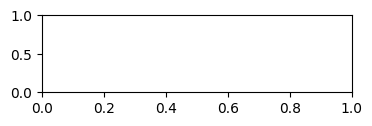

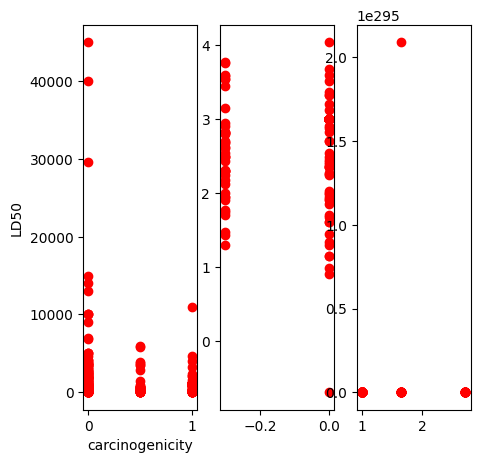

In [76]:
# LD50_rat vs carcinogenicity
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(5, 5))

ax0.scatter(df_stats['carcinogenicity'],df_stats['LD50_rat'], color='red')
ax0.set(xlabel='carcinogenicity', ylabel='LD50')

log_y1 = np.log10(df_stats['LD50_rat'])
log_x = np.log10(df_stats['carcinogenicity'])
df1 = pd.DataFrame({'x': log_x, 'y': log_y1})
ax1.scatter(log_x, log_y1, color='red')

exp_y1 = np.exp(df_stats['LD50_rat'])
exp_x = np.exp(df_stats['carcinogenicity'])
df1 = pd.DataFrame({'x': exp_x, 'y': exp_y1})
ax2.scatter(exp_x, exp_y1, color='red')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


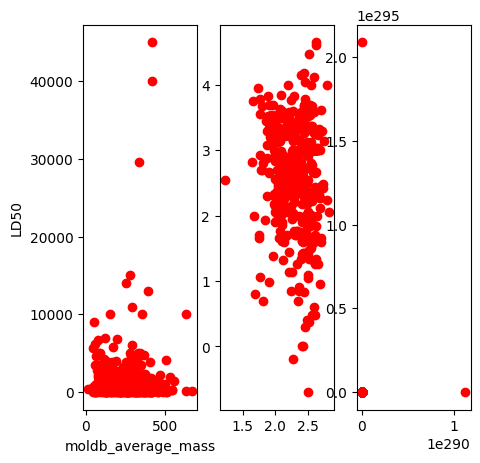

In [77]:
# LD50_rat vs moldb_average_mass
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(5, 5))

ax0.scatter(df_stats['moldb_average_mass'],df_stats['LD50_rat'], color='red')
ax0.set(xlabel='moldb_average_mass', ylabel='LD50')

log_y1 = np.log10(df_stats['LD50_rat'])
log_x = np.log10(df_stats['moldb_average_mass'])
df1 = pd.DataFrame({'x': log_x, 'y': log_y1})
ax1.scatter(log_x, log_y1, color='red')

exp_y1 = np.exp(df_stats['LD50_rat'])
exp_x = np.exp(df_stats['moldb_average_mass'])
df1 = pd.DataFrame({'x': exp_x, 'y': exp_y1})
ax2.scatter(exp_x, exp_y1, color='red')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


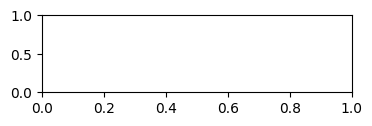

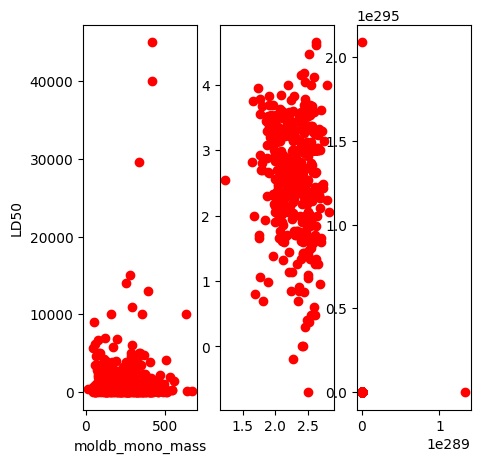

In [78]:
# LD50_rat vs moldb_mono_mass
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(5, 5))

ax0.scatter(df_stats['moldb_mono_mass'],df_stats['LD50_rat'], color='red')
ax0.set(xlabel='moldb_mono_mass', ylabel='LD50')

log_y1 = np.log10(df_stats['LD50_rat'])
log_x = np.log10(df_stats['moldb_mono_mass'])
df1 = pd.DataFrame({'x': log_x, 'y': log_y1})
ax1.scatter(log_x, log_y1, color='red')

exp_y1 = np.exp(df_stats['LD50_rat'])
exp_x = np.exp(df_stats['moldb_mono_mass'])
df1 = pd.DataFrame({'x': exp_x, 'y': exp_y1})
ax2.scatter(exp_x, exp_y1, color='red')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


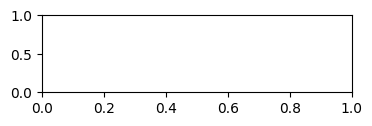

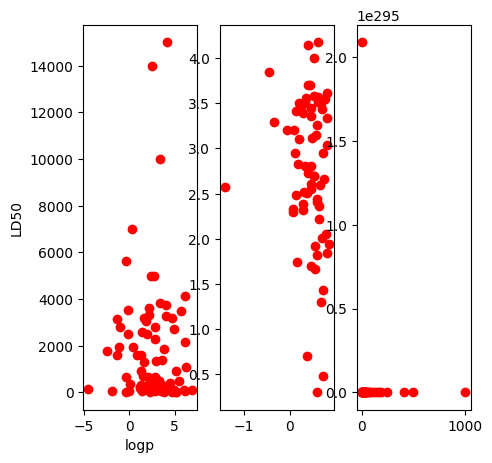

In [79]:
# LD50_rat vs logp
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(5, 5))

ax0.scatter(df_stats['logp'],df_stats['LD50_rat'], color='red')
ax0.set(xlabel='logp', ylabel='LD50')

log_y1 = np.log10(df_stats['LD50_rat'])
log_x = np.log10(df_stats['logp'])
df1 = pd.DataFrame({'x': log_x, 'y': log_y1})
ax1.scatter(log_x, log_y1, color='red')

exp_y1 = np.exp(df_stats['LD50_rat'])
exp_x = np.exp(df_stats['logp'])
df1 = pd.DataFrame({'x': exp_x, 'y': exp_y1})
ax2.scatter(exp_x, exp_y1, color='red')

<Axes: >

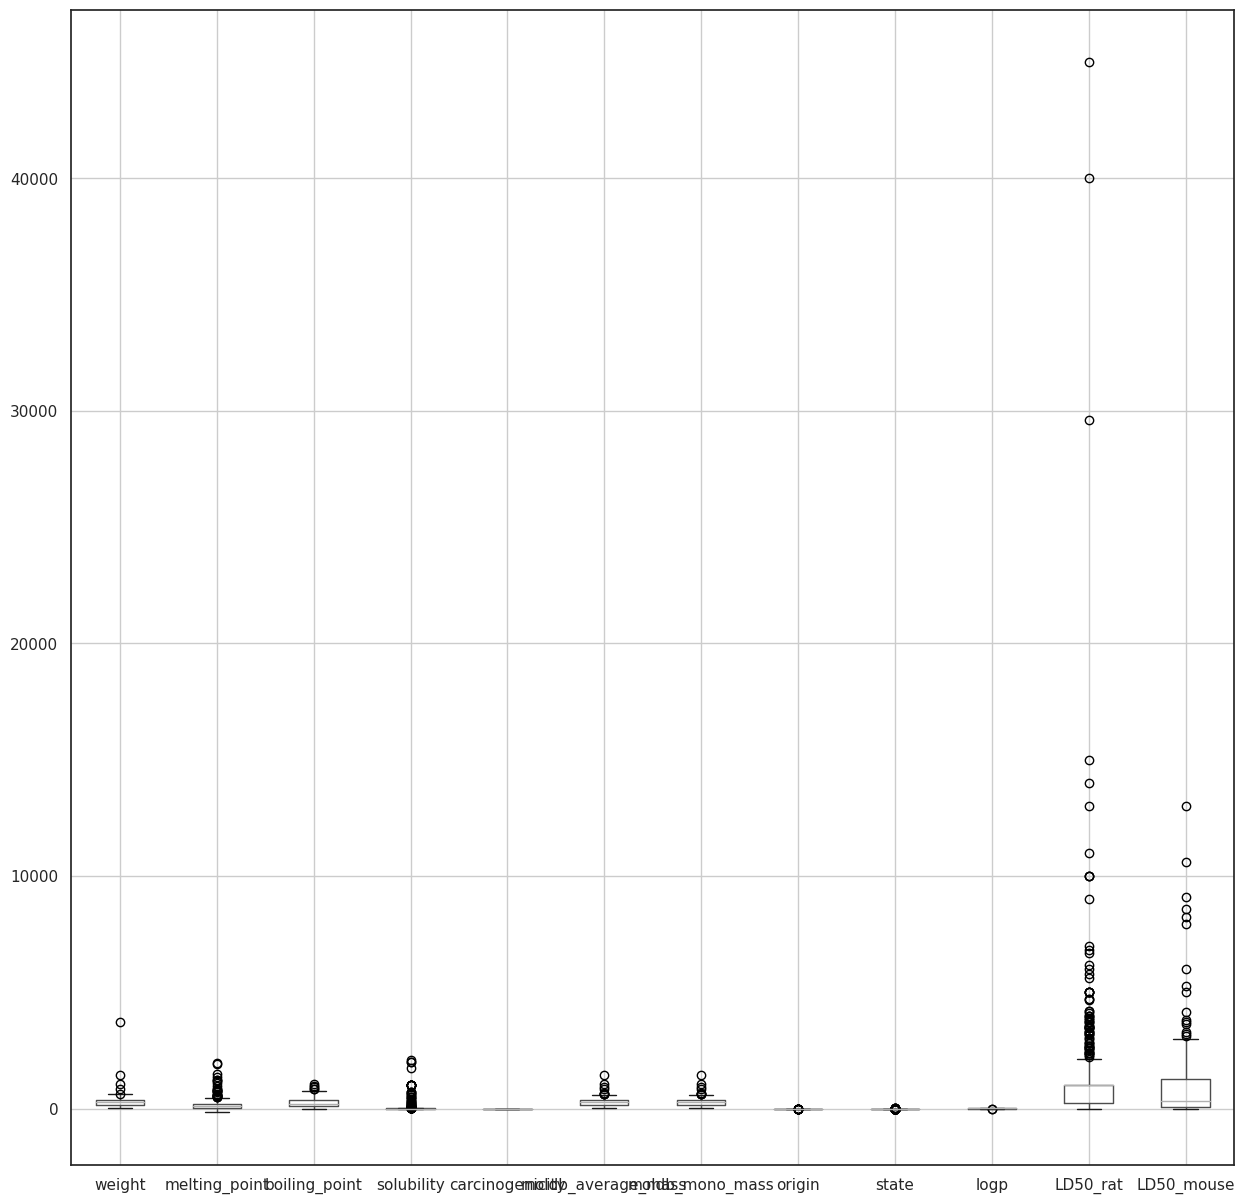

In [ ]:
#Boxplots 

df_stats.boxplot()

In [ ]:
#======================================= Incorporation of the fingerprints into the dataset =======================================#
path = "/content/drive/My Drive/Toxicity Project/DATA/updated_df.csv"
df = pd.read_csv(path)

In [ ]:
dir(QED.QEDproperties)

['ALERTS',
 'ALOGP',
 'AROM',
 'HBA',
 'HBD',
 'MW',
 'PSA',
 'ROTB',
 '__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_fields',
 '_make',
 '_replace',
 'count',
 'index']

In [ ]:
ls = ["h",",","6"]
x = "X"
ls.insert(0,x)
print(ls)

['X', 'h', ',', '6']


In [ ]:
columns = ["Surface_Area",'ALERTS','ALOGP','AROM','HBA','HBD','MW','PSA','ROTB']+[f"fp{n}" for n in range(1,129)]
nans = 0
print(columns)
for i in tqdm(df.index):
    try:
        mol = Chem.MolFromSmiles(df.loc[i,"moldb_smiles"])
        SA = float(MolSurf.LabuteASA(mol))
        props = list(QED.properties(mol)[:])
        finger = np.asarray(Chem.GetMorganFingerprintAsBitVect(mol,2,128))
        props.insert(0,SA)
        local = np.array(props)
        local = np.append(local, finger)
        df.loc[i,columns] = local

    except:
        nans+=1
        df.loc[i,columns] = None
        
print(f"Nans: {nans}")

['Surface_Area', 'ALERTS', 'ALOGP', 'AROM', 'HBA', 'HBD', 'MW', 'PSA', 'ROTB', 'fp1', 'fp2', 'fp3', 'fp4', 'fp5', 'fp6', 'fp7', 'fp8', 'fp9', 'fp10', 'fp11', 'fp12', 'fp13', 'fp14', 'fp15', 'fp16', 'fp17', 'fp18', 'fp19', 'fp20', 'fp21', 'fp22', 'fp23', 'fp24', 'fp25', 'fp26', 'fp27', 'fp28', 'fp29', 'fp30', 'fp31', 'fp32', 'fp33', 'fp34', 'fp35', 'fp36', 'fp37', 'fp38', 'fp39', 'fp40', 'fp41', 'fp42', 'fp43', 'fp44', 'fp45', 'fp46', 'fp47', 'fp48', 'fp49', 'fp50', 'fp51', 'fp52', 'fp53', 'fp54', 'fp55', 'fp56', 'fp57', 'fp58', 'fp59', 'fp60', 'fp61', 'fp62', 'fp63', 'fp64', 'fp65', 'fp66', 'fp67', 'fp68', 'fp69', 'fp70', 'fp71', 'fp72', 'fp73', 'fp74', 'fp75', 'fp76', 'fp77', 'fp78', 'fp79', 'fp80', 'fp81', 'fp82', 'fp83', 'fp84', 'fp85', 'fp86', 'fp87', 'fp88', 'fp89', 'fp90', 'fp91', 'fp92', 'fp93', 'fp94', 'fp95', 'fp96', 'fp97', 'fp98', 'fp99', 'fp100', 'fp101', 'fp102', 'fp103', 'fp104', 'fp105', 'fp106', 'fp107', 'fp108', 'fp109', 'fp110', 'fp111', 'fp112', 'fp113', 'fp114', 'fp

  0%|          | 0/669 [00:00<?, ?it/s]

[08:00:38] Explicit valence for atom # 0 O, 3, is greater than permitted


Nans: 1


In [ ]:
corr_mat = df.loc[:,["Surface_Area",'ALERTS','ALOGP','AROM','HBA','HBD','MW','PSA','ROTB','LD50_rat','LD50_mouse']].corr()

sb.heatmap(corr_mat, annot=True, cmap= "coolwarm")
plt.title("Correlation matrix of numeric columns")
plt.show()

NameError: ignored

In [ ]:
plt.figure()
plt.xlim(0,10000)
sb.histplot(df['LD50_mouse'],stat="density",alpha=0.5,binwidth=200,label="mouse")
sb.histplot(df['LD50_rat'],stat="density",alpha=0.4,binwidth=200,label="rat")
plt.xlabel("LD50 (mg/kg)")
plt.legend()

In [ ]:
print(len(df))
df = df.dropna(0,subset="LD50_rat")
print(len(df))

In [ ]:
# creates a column called binary_rat_ld50 which is the binary categorization of the LD50
binary_rat_ld50 = np.zeros(len(df))
binary_rat_ld50[np.argwhere(np.array(df["LD50_rat"])>df["LD50_rat"].median())] = 1

df["binary_rat_ld50"] = binary_rat_ld50

In [ ]:
def threestar(df,col):
    df ["index"]=list(range(len(df)))
    df = df.set_index("index")
    first = df[col].quantile(1/3)
    onestar = df.query(f"{col}<={first}")
    df.loc[onestar.index, f"{col}_level"] = 1
    print(first)
    second = df[col].quantile(2/3)
    twostar = df.query(f"{col}<={second} and {col}>{first}")
    df.loc[twostar.index, f"{col}_level"] = 2
    print(second)
    threestar = df.query(f"{col}>{second}")
    df.loc[threestar.index, f"{col}_level"] = 3
    
    plt.figure()
    plt.xlim(0,10000)
    sb.histplot(data=df,x=col, hue=f"{col}_level",palette="viridis",binwidth=100)
    plt.savefig("data_level_distribution.pdf")
    plt.show()

    plt.figure()
    plt.xlim(0,10000)
    sb.histplot(data=df,y=f"{col}_level",x=col)
    plt.savefig("level_distribution.pdf")
    plt.show()
    
    return df

df = threestar(df,"LD50_rat")

In [ ]:
path = "/content/drive/My Drive/Toxicity Project/DATA/fingerprint_df.csv"
df.to_csv(path)

In [ ]:
#Variance inflation factor (VIF). Shows multicolinearity
#Drop variables with vif higher than 5-10

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = df_stats.columns
vif